In [ ]:
"""
 - no merging APs - separate APs work better 
 - Average works best (99% 1 step + 2 steps, pixel) (98% 1 step + 2 steps, redmi)
 - weighting by power used / total power received doesn't work 
 - KS doesnt work 
 - Average > Median > Max 
 - random direction = disaster 
 - sometimes RSSI data from an AP is missing (not received) -> misclassification
"""

In [85]:
from utils import *
import sys, os, random
# from compare_locations import compare_locations

datadir = "../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json"]



In [60]:
datadir = "../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
"1-pixel-25-02-2021_21-16-46.json.gz",
"2-pixel-25-02-2021_16-27-45.json.gz",
"3-pixel-04-03-2021_16-18-50.json.gz",
"4-pixel-04-03-2021_16-43-50.json.gz",
"5-pixel-04-03-2021_17-11-32.json.gz",
"6-pixel-17-03-2021_12-52-29.json.gz",
"7-pixel-17-03-2021_13-14-36.json.gz"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
"2-redmi-25-02-2021_16-27-08.json.gz",
"3-redmi-04-03-2021_16-18-52.json.gz",
"4-redmi-04-03-2021_16-43-45.json.gz",
"5-redmi-04-03-2021_17-11-30.json.gz",
"6-redmi-17-03-2021_12-52-29.json.gz",
"7-redmi-17-03-2021_13-14-39.json.gz"]



In [61]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    petaje.append(etaj)
    

In [62]:
print(retaje[0][45])
#print(retaje[0][48])


{'devId': '62a658f7-0ce0-4339-acdf-33d39c45e190', 'devName': 'Redmi Note 8', 'AndroidVersion': '10', 'comment': 'Comment l3', 'map': 'arch_precis_parter.png', 'x': 54.37, 'y': 20.44, 'z': 86.5, 'fingerprints': [{'timestamp': '04-03-2021 15:30:29', 'wifi': {'84:b2:61:5e:62:bf': {'ssid': 'eduroam', 'frequency': '5500', 'rssi': [-83]}, '84:b2:61:65:f2:21': {'ssid': 'UPB-Guest', 'frequency': '2462', 'rssi': [-63]}, '84:b2:61:5e:62:be': {'ssid': 'UPB-Guest', 'frequency': '5500', 'rssi': [-84]}, '84:b2:61:65:f2:20': {'ssid': 'eduroam', 'frequency': '2462', 'rssi': [-62]}, '84:b2:61:5e:62:bd': {'ssid': 'PRECIS', 'frequency': '5500', 'rssi': [-82]}, '84:b2:61:56:54:cf': {'ssid': 'eduroam', 'frequency': '5320', 'rssi': [-81]}, '84:b2:61:56:54:cd': {'ssid': 'PRECIS', 'frequency': '5320', 'rssi': [-81]}, '84:b2:61:5e:62:b0': {'ssid': 'eduroam', 'frequency': '2437', 'rssi': [-84]}, 'e4:aa:5d:84:a8:7f': {'ssid': 'eduroam', 'frequency': '5300', 'rssi': [-59]}, 'e4:aa:5d:84:a8:7e': {'ssid': 'UPB-Gues

In [134]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def merge_wifi_fingerprints(flist):
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    
    """
    
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    rssi1 = []
    rssi2 = []
    w = [] #weight for braycurtis
    
    # take the first fingerprint in the list 
    #wifi1 = c1['fingerprints'][0]['wifi']
    #wifi2 = c2['fingerprints'][0]['wifi']

    # take a random fingerprint in the list 
    #wifi1 = c1['fingerprints'][random.randint(0,3)]['wifi']
    #wifi2 = c2['fingerprints'][random.randint(0,3)]['wifi']

    # first & third - as if measuring twice at 180 degrees
    #wifi1 = merge_wifi_fingerprints([c1['fingerprints'][0], c1['fingerprints'][2]])['wifi']
    #wifi2 = merge_wifi_fingerprints([c2['fingerprints'][0], c2['fingerprints'][2]])['wifi']
    
    #merge all existing fingerprints for each collection
    wifi1 = merge_wifi_fingerprints(c1['fingerprints'])['wifi']
    wifi2 = merge_wifi_fingerprints(c2['fingerprints'])['wifi']
    
    # all power received by the query
    power1 = 0
    for ap in wifi1:
        power1 += np.sum(wifi1[ap]['rssi'])
        
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    
    #print("common aps=", len(common_aps))
    
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1

    # TODO: find the best metric
    # If not enough common APs -> similarity = 1
    if len(common_aps) * 3 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1

    for ap in common_aps:
        
        if selection == 'Bestdir':
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(adjust_rssi(f1['wifi'][ap]['rssi']))
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(adjust_rssi(f2['wifi'][ap]['rssi']))
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
        if selection == 'First':
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
        if selection == 'Average':
            #rssi1.append(adjust_rssi(np.average(wifi1[ap]['rssi']))[0])
            #rssi2.append(adjust_rssi(np.average(wifi2[ap]['rssi']))[0])
            rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            #w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

        if selection == 'Median':
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Mean':
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Std':
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Max':
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
        if selection == 'KS':
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

        if selection == 'Tempered':
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
    
    
    rssi11 = []
    rssi22 = []
    if selection != 'KS':
        if (dif == True):
            #print(rssi1)
            rssi11.append(np.diff(rssi1, append=rssi1[0]))
            rssi22.append(np.diff(rssi2, append=rssi2[0]))
            rssi1 = rssi11
            rssi2 = rssi22        
    
    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    """
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))

    
    if simil_method == real_braycurtis:        
        rssi_only1 = []
        rssi_only2 = []
        
        for ap in aps1:
            rssi_only1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
        for ap in aps2:
            rssi_only2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
        ms = np.sum(rssi_only1) + np.sum(rssi_only2)
        realbc =  real_braycurtis(np.array(rssi1), np.array(rssi2), ms)
                                  #np.array(rssi_only1), np.array(rssi_only2))
        #print(type(rssi1))
        #print(f"1={rssi_only1} 2={rssi_only2} o1={np.sum(rssi_only1)} o2={np.sum(rssi_only2)}")
        #umv = np.abs(np.array(rssi1) - np.array(rssi2)).sum() 
        #upv = np.abs(np.array(rssi1) + np.array(rssi2)).sum() 
        #print(f"u-v={umv}  u+v={upv}")
        bc = correlation(rssi1, rssi2)
        return bc, realbc, 1.0 - iou
    
    #print("normal")
    #return simil_method(np.array(rssi1), np.array(rssi2))   
#   return  * 
    #print(rssi1)
    return simil_method(rssi1, rssi2)

# weigh final result with used power/total power   

In [ ]:
def compare_locations_f(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    rssi1 = []
    rssi2 = []
    
    wifi1 = merge_wifi_fingerprints(c1['fingerprints'])['wifi']
    wifi2 = merge_wifi_fingerprints(c2['fingerprints'])['wifi']
    
    # all power received by the query
    power1 = 0
    for ap in wifi1:
        power1 += np.sum(wifi1[ap]['rssi'])
        
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    total_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    
    if len(common_aps) * 3 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1

    for ap in common_aps:
        
        if selection == 'Average':
            #if ap in wifi1:
                rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            #else
            #    rssi1.append(0.0)
            #if ap in wifi1:    
                rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            #else:
            #    rssi2.append(0.0)
            
        if selection == 'Median':
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Mean':
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Std':
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Max':
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
        if selection == 'KS':
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

        if selection == 'Tempered':
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
    
    
    rssi11 = []
    rssi22 = []
    if selection != 'KS':
        if (dif == True):
            #print(rssi1)
            rssi11.append(np.diff(rssi1, append=rssi1[0]))
            rssi22.append(np.diff(rssi2, append=rssi2[0]))
            rssi1 = rssi11
            rssi2 = rssi22        
    
    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    """
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))

    
    if simil_method == real_braycurtis:        
        rssi_only1 = []
        rssi_only2 = []
        
        for ap in aps1:
            rssi_only1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
        for ap in aps2:
            rssi_only2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
        ms = np.sum(rssi_only1) + np.sum(rssi_only2)
        realbc =  real_braycurtis(np.array(rssi1), np.array(rssi2), ms)
                                  #np.array(rssi_only1), np.array(rssi_only2))
        #print(type(rssi1))
        #print(f"1={rssi_only1} 2={rssi_only2} o1={np.sum(rssi_only1)} o2={np.sum(rssi_only2)}")
        #umv = np.abs(np.array(rssi1) - np.array(rssi2)).sum() 
        #upv = np.abs(np.array(rssi1) + np.array(rssi2)).sum() 
        #print(f"u-v={umv}  u+v={upv}")
        bc = correlation(rssi1, rssi2)
        return bc, realbc, 1.0 - iou
    
    #print("normal")
    #return simil_method(np.array(rssi1), np.array(rssi2))   
#   return  * 
    #print(rssi1)
    return simil_method(rssi1, rssi2)

# weigh final result with used power/total power   

In [136]:
print("bray ", compare_locations(retaje[0][0], retaje[0][1], dif=True, simil_method=braycurtis))
print("real ", compare_locations(retaje[0][0], retaje[0][1], dif=True, simil_method=real_braycurtis))

bray  0.12319258165194648
real  (0.020700883935974246, 0.16856935167153247, 0.43103448275862066)


In [144]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = retaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
minra = []
for e in range(0,len(etaje)): 
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q+1,len(etaje[e])):
            if p > q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 7.0: 
                    continue
                bc, realbc, iou = compare_locations(etaje[e][q], etaje[e][p], \
                                                 selection = 'Average', \
                                              dif=False, simil_method=real_braycurtis)
                #    real_braycurtis returns python bc, new_bc, and intersection/union      
                R = 2.0
                if math.sqrt(bc) < 0.35: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                    
                bd.append([ q, p, eu_dist, bc, realbc, iou])
after = datetime.datetime.now()

print(f"R= {R} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f}")
print(f"Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

R= 2.0 Precision= 0.37 Recall= 0.99
Pdist = [2.31272727 4.77001559 6.13769746] 
Slope = 0.06


###precis-02
-R = 2.0 bc < 0.29/avg Precision = 0.47 Recall = 0.99 FP up to 4.8m 95% 
-R = 2.0 bc < 0.32/max Precision = 0.51 Recall = 0.99 FP up to 4.4m 95% 
-R = 2.5 bc < 0.35/max Precision = 0.55 Recall = 0.99 FP up to 4.8m 95% 
-R = 3.0 bc < 0.38/max Precision = 0.56 Recall = 0.99 FP up to 5.1m 95% 
braycurtis ~ cosine ~ correlation 
R = 2.0 cor<0.11/avg/nodiff Precision = 0.56 Recall = 0.99 FP up to 4.2m 95%  - BEST 
R = 2.0 rbc < 0.25/avg/diff Precision= 0.52 Recall= 0.99 FP up to 4.2m 95% 

###precis-01
-R= 2.0m bc < 0.23/Avg Precision= 0.35 Recall= 0.99 false positives up to @5.3m 95% 
-R= 2.5m bc < 0.28/Avg Precision= 0.49 Recall= 0.99 false positives up to @5.8m 95% 
-R= 4.0m bc < 0.39/Avg Precision= 0.61 Recall= 0.99 false positives up to @6.4m 95% 
-R= 2.0m realbc<0.22/avg/diff Precision= 0.36 Recall= 0.99 FP up to 4.6m 95% - BEST 

Slope = [0.00149435 0.06396059 0.0972672 ]
Slope = [0.0004543  0.03906814 0.06322603]


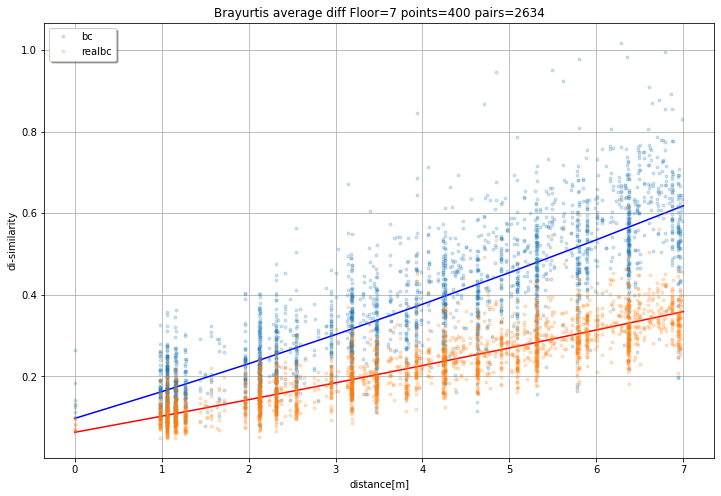

In [140]:
fig =  plt.figure(figsize=(12, 8))     # bc, realbc, iou   
m = np.polyfit([r[2] for r in bd] , [math.sqrt(r[3]) for r in bd], 2)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 8)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')
m = np.polyfit([r[2] for r in bd] , [r[4] for r in bd], 2)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 8)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'r')

# r =  q, p, eu_dist, bc, rbc, iou 
plt.plot([r[2] for r in bd] , [math.sqrt(r[3]) for r in bd], ".", label='bc', alpha=0.2)
plt.plot([r[2] for r in bd] , [r[4] for r in bd], ".", label='realbc', alpha=0.2)
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Brayurtis average diff Floor={e} points={npct} pairs={len(bd)}")
#plt.xticks(range(0, 20, 2))
#plt.ylim(0, 0.5)
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()

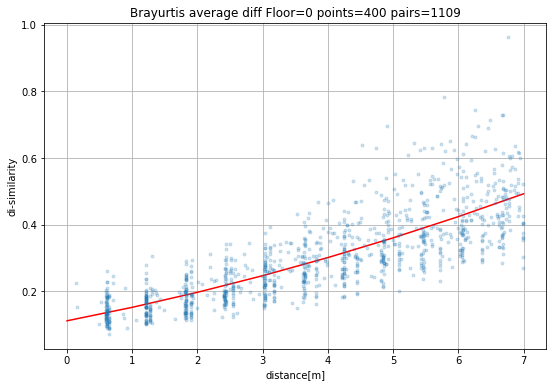

In [148]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average'):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], braycurtis, selection)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average'):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1000.0 
    mini = -1; 
    for c in range(0, len(collections)):
        bc, d, iou = compare_locations(query, collections[c], real_braycurtis, dif=True)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  
    

In [150]:
#  query = Pixel  
#  DB = redmi 
cl_sim = []
cl_steps = []
cl_dist = []

#for e in len(retaje):
for e in range(0, len(petaje)): 
    for p in range(0, len(petaje[e])):
        sim, index, d =  test_queryvsall(petaje[e][p], retaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        #cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)
  
print(np.percentile(cl_dist, [50, 95, 99]))

[1.06       2.33932184 3.46909091]


real + True [0.98153846 2.12666667]
bc + True [0.98153846 2.12666667 2.55557152]

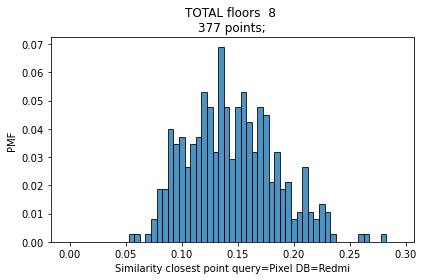

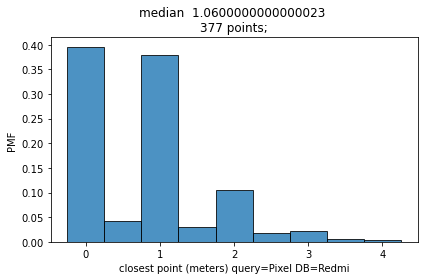

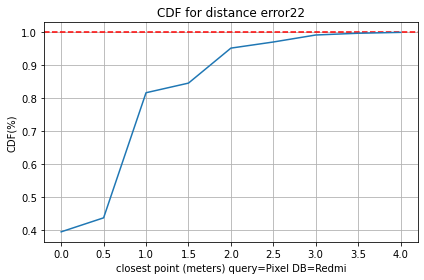

In [153]:

b = np.arange(0, 0.3, 0.005) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity closest point query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("TOTAL floors ", len(retaje), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(0, 5, 0.5) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("PMF")
plt.title("{} {} \n{}{}".format("median ", np.median(cl_dist), len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
#    fig.savefig(f"{method}-{len(etaje)}.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters) query=Pixel DB=Redmi")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("CDF for distance error", 22))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.show()

